notice : spacy doesn't work.
it needs to build

In [4]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import numpy as np
import warnings, os, sys, csv, json
import sklearn
import scipy
import nltk
import gensim

sns.set(style='white', context='notebook', palette='deep')
warnings.filterwarnings('ignore')
sns.set_style('white')
%matplotlib inline

In [5]:
origin_path = '../../dataset/origin/'
gendered_pronoun_df = pd.read_csv(origin_path+'test_stage_1.tsv', sep='\t')
submission = pd.read_csv(origin_path+'sample_submission_stage_1.csv')

In [6]:
gendered_pronoun_df.shape, submission.shape

((2000, 9), (2000, 4))

### Variables 
1. ID - Unique identifier for an example (Matches to Id in output file format)
1. Text - Text containing the ambiguous pronoun and two candidate names (about a paragraph in length)
1. Pronoun - The target pronoun (text)
1. Pronoun-offset The character offset of Pronoun in Text
1. A - The first name candidate (text)
1. A-offset - The character offset of name A in Text
1. B - The second name candidate
1. B-offset - The character offset of name B in Text
1. URL - The URL of the source Wikipedia page for the example

In [7]:
# evaluation : logloss

In [42]:
# new features
# number of words in the text
gendered_pronoun_df['num_words'] = gendered_pronoun_df['Text'].apply(lambda x: len(str(x).split()))

# number of unique words in the text
gendered_pronoun_df['num_unique_words'] = gendered_pronoun_df['Text'].apply(lambda x: len(set(str(x).split())))

# number of characters in the text
gendered_pronoun_df['num_chars'] = gendered_pronoun_df['Text'].apply(lambda x : len(str(x)))

# number of stopwords in the text
# nltk.download('stopwords')
from nltk.corpus import stopwords
eng_stopwords = set(stopwords.words("english"))

gendered_pronoun_df["num_stopwords"] = gendered_pronoun_df["Text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

# number of punctuations in the text
import string
gendered_pronoun_df["num_punctuations"] = gendered_pronoun_df['Text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# number of title case words in the text
gendered_pronoun_df['num_words_upper'] = gendered_pronoun_df['Text'].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

# encode pronoun
pronoun_encoder = {'he':0, 'she':1, 'his':2, 'him':3, 'her':4}
def pronoun_encoding(x):
    return pronoun_encoder[x.lower()]
gendered_pronoun_df['pronoun_multi_class'] = gendered_pronoun_df['Pronoun'].apply(pronoun_encoding)

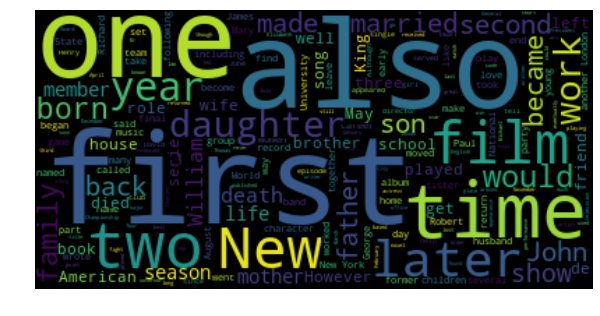

In [14]:
# viz
from wordcloud import WordCloud as wc
eng_stopwords = set(stopwords.words('english'))
def generate_wordcloud(text):
    wordcloud = wc(relative_scaling = 1.0, stopwords = eng_stopwords).generate(text)
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.margins(x=0, y=0)
    plt.show()
text = " ".join(gendered_pronoun_df.Text)
generate_wordcloud(text)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000028EA4F29518>,
      dtype=object)

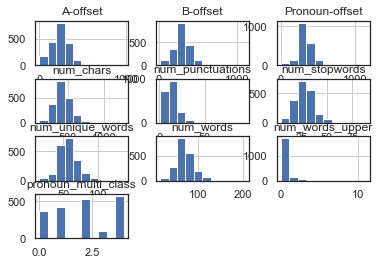

In [15]:
gendered_pronoun_df.hist()

<Figure size 432x288 with 0 Axes>

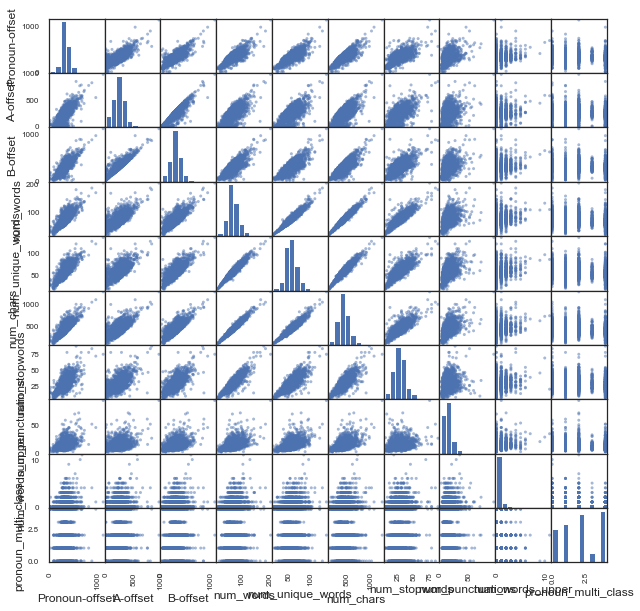

<Figure size 432x288 with 0 Axes>

In [16]:
pd.plotting.scatter_matrix(gendered_pronoun_df, figsize=(10,10))
plt.figure()

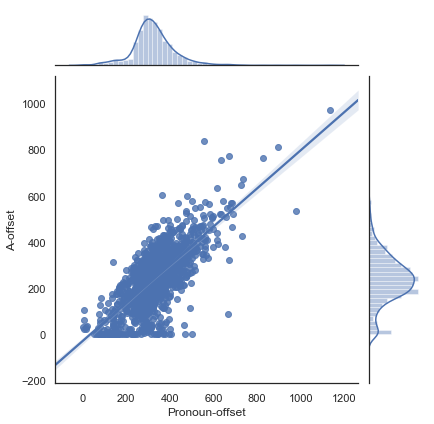

In [17]:
sns.jointplot(x='Pronoun-offset', y='A-offset', data=gendered_pronoun_df, kind='reg')

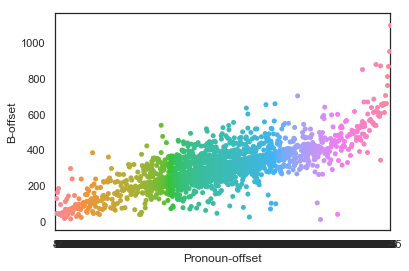

In [18]:
sns.swarmplot(x='Pronoun-offset', y='B-offset', data=gendered_pronoun_df)

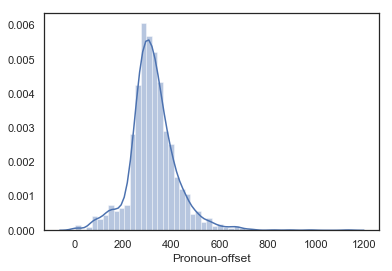

In [20]:
sns.distplot(gendered_pronoun_df['Pronoun-offset'])

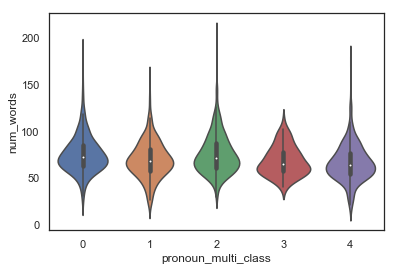

In [22]:
sns.violinplot(data=gendered_pronoun_df, x="pronoun_multi_class", y = "num_words")

## Python Sentiment Analysis
1. text input
1. tokenization
1. stop word filtering
1. negation handling
1. stemming
1. classification
1. sentiment class
1. repeat

## Top 3 NLP Libraries Tutorial
### NLTK
- Natural Language ToolKit
- tokenizing words and sentences
- mine(scrap and upload data)
- analyse very large data

#### Tokenizing sentences
- tokenization : the process of breaking a stream of text up into words, phrases, symbols, or other meaningful elements called tokens

#### stop words
-  a stop word is a commonly used word (such as "the") that a search engine has been programmed to ignore

#### stemming
- character by character

#### speech tagging
- 

In [26]:
our_text = gendered_pronoun_df['Text'][0]

In [41]:
# nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
phrases = sent_tokenize(our_text)
words = word_tokenize(our_text)
print(phrases)
print(words)

['Zoe Telford -- played the police officer girlfriend of Simon, Maggie.', 'Dumped by Simon in the final episode of series 1, after he slept with Jenny, and is not seen again.', "Phoebe Thomas played Cheryl Cassidy, Pauline's friend and also a year 11 pupil in Simon's class.", "Dumped her boyfriend following Simon's advice after he wouldn't have sex with her but later realised this was due to him catching crabs off her friend Pauline."]
['Zoe', 'Telford', '--', 'played', 'the', 'police', 'officer', 'girlfriend', 'of', 'Simon', ',', 'Maggie', '.', 'Dumped', 'by', 'Simon', 'in', 'the', 'final', 'episode', 'of', 'series', '1', ',', 'after', 'he', 'slept', 'with', 'Jenny', ',', 'and', 'is', 'not', 'seen', 'again', '.', 'Phoebe', 'Thomas', 'played', 'Cheryl', 'Cassidy', ',', 'Pauline', "'s", 'friend', 'and', 'also', 'a', 'year', '11', 'pupil', 'in', 'Simon', "'s", 'class', '.', 'Dumped', 'her', 'boyfriend', 'following', 'Simon', "'s", 'advice', 'after', 'he', 'would', "n't", 'have', 'sex', '

In [30]:
from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))
words = word_tokenize(our_text)
wordsFiltered = []
for w in words :
    if w not in stopWords :
        wordsFiltered.append(w)
print(wordsFiltered)

['Zoe', 'Telford', '--', 'played', 'police', 'officer', 'girlfriend', 'Simon', ',', 'Maggie', '.', 'Dumped', 'Simon', 'final', 'episode', 'series', '1', ',', 'slept', 'Jenny', ',', 'seen', '.', 'Phoebe', 'Thomas', 'played', 'Cheryl', 'Cassidy', ',', 'Pauline', "'s", 'friend', 'also', 'year', '11', 'pupil', 'Simon', "'s", 'class', '.', 'Dumped', 'boyfriend', 'following', 'Simon', "'s", 'advice', 'would', "n't", 'sex', 'later', 'realised', 'due', 'catching', 'crabs', 'friend', 'Pauline', '.']


In [31]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()
for word in our_text:
    print(ps.stem(word))

Z
o
e
 
T
e
l
f
o
r
d
 
-
-
 
p
l
a
y
e
d
 
t
h
e
 
p
o
l
i
c
e
 
o
f
f
i
c
e
r
 
g
i
r
l
f
r
i
e
n
d
 
o
f
 
S
i
m
o
n
,
 
M
a
g
g
i
e
.
 
D
u
m
p
e
d
 
b
y
 
S
i
m
o
n
 
i
n
 
t
h
e
 
f
i
n
a
l
 
e
p
i
s
o
d
e
 
o
f
 
s
e
r
i
e
s
 
1
,
 
a
f
t
e
r
 
h
e
 
s
l
e
p
t
 
w
i
t
h
 
J
e
n
n
y
,
 
a
n
d
 
i
s
 
n
o
t
 
s
e
e
n
 
a
g
a
i
n
.
 
P
h
o
e
b
e
 
T
h
o
m
a
s
 
p
l
a
y
e
d
 
C
h
e
r
y
l
 
C
a
s
s
i
d
y
,
 
P
a
u
l
i
n
e
'
s
 
f
r
i
e
n
d
 
a
n
d
 
a
l
s
o
 
a
 
y
e
a
r
 
1
1
 
p
u
p
i
l
 
i
n
 
S
i
m
o
n
'
s
 
c
l
a
s
s
.
 
D
u
m
p
e
d
 
h
e
r
 
b
o
y
f
r
i
e
n
d
 
f
o
l
l
o
w
i
n
g
 
S
i
m
o
n
'
s
 
a
d
v
i
c
e
 
a
f
t
e
r
 
h
e
 
w
o
u
l
d
n
'
t
 
h
a
v
e
 
s
e
x
 
w
i
t
h
 
h
e
r
 
b
u
t
 
l
a
t
e
r
 
r
e
a
l
i
s
e
d
 
t
h
i
s
 
w
a
s
 
d
u
e
 
t
o
 
h
i
m
 
c
a
t
c
h
i
n
g
 
c
r
a
b
s
 
o
f
f
 
h
e
r
 
f
r
i
e
n
d
 
P
a
u
l
i
n
e
.


In [40]:
# nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import PunktSentenceTokenizer
sentences = nltk.sent_tokenize(our_text)
for sent in sentences :
    print(nltk.pos_tag(nltk.word_tokenize(sent)))

[('Zoe', 'NNP'), ('Telford', 'NNP'), ('--', ':'), ('played', 'VBD'), ('the', 'DT'), ('police', 'NN'), ('officer', 'NN'), ('girlfriend', 'NN'), ('of', 'IN'), ('Simon', 'NNP'), (',', ','), ('Maggie', 'NNP'), ('.', '.')]
[('Dumped', 'VBN'), ('by', 'IN'), ('Simon', 'NNP'), ('in', 'IN'), ('the', 'DT'), ('final', 'JJ'), ('episode', 'NN'), ('of', 'IN'), ('series', 'NN'), ('1', 'CD'), (',', ','), ('after', 'IN'), ('he', 'PRP'), ('slept', 'VBD'), ('with', 'IN'), ('Jenny', 'NNP'), (',', ','), ('and', 'CC'), ('is', 'VBZ'), ('not', 'RB'), ('seen', 'VBN'), ('again', 'RB'), ('.', '.')]
[('Phoebe', 'NNP'), ('Thomas', 'NNP'), ('played', 'VBD'), ('Cheryl', 'NNP'), ('Cassidy', 'NNP'), (',', ','), ('Pauline', 'NNP'), ("'s", 'POS'), ('friend', 'NN'), ('and', 'CC'), ('also', 'RB'), ('a', 'DT'), ('year', 'NN'), ('11', 'CD'), ('pupil', 'NN'), ('in', 'IN'), ('Simon', 'NNP'), ("'s", 'POS'), ('class', 'NN'), ('.', '.')]
[('Dumped', 'NNP'), ('her', 'PRP$'), ('boyfriend', 'NN'), ('following', 'VBG'), ('Simon', 'N

In [36]:
from nltk.corpus import state_union
sentences = nltk.sent_tokenize(our_text)
data = []
for sent in sentences:
    data = data + nltk.pos_tag(nltk.word_tokenize(sent))
for word in data:
    if 'NNP' in word[1]:
        print(word)

('Zoe', 'NNP')
('Telford', 'NNP')
('Simon', 'NNP')
('Maggie', 'NNP')
('Simon', 'NNP')
('Jenny', 'NNP')
('Phoebe', 'NNP')
('Thomas', 'NNP')
('Cheryl', 'NNP')
('Cassidy', 'NNP')
('Pauline', 'NNP')
('Simon', 'NNP')
('Dumped', 'NNP')
('Simon', 'NNP')
('Pauline', 'NNP')


#### NLP prediction
1. data preparation
1. feature extraction
1. training
1. prediction

##### Data Preparation

In [39]:
# names set included w/ nltk
# nltk.download('names')
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import names

def gender_features(word):
    return {'last_letter':word[-1]}

names = ([(name, 'male') for name in names.words('male.txt')]+[(name, 'female') for name in names.words('female.txt')])

featuresets = [(gender_features(n), g) for (n,g) in names]
train_set = featuresets
classifier = nltk.NaiveBayesClassifier.train(train_set)
print(classifier.classify(gender_features('Frank')))
print(classifier.classify(gender_features('Sarah')))

male
female


### spaCy

- Industrial-Strength Natural Language Processing in python

In [44]:
import spacy

ModuleNotFoundError: No module named 'spacy'

### Gensim
- for topic modeling, document indexing and similarity retrieval w/ large corpora
- target : NLP, information retrieval(IR)
- Scalable statistical semantics
- Analyze plain-text documnets for semantic structure
- Retrieve semantically similar documents

In [49]:
import gensim
from gensim import corpora
from pprint import pprint
texts = [our_text.split(), our_text.split()]
dictionary = corpora.Dictionary(texts)
print(dictionary)
print(dictionary.token2id)

Dictionary(61 unique tokens: ['--', '1,', '11', 'Cassidy,', 'Cheryl']...)
{'--': 0, '1,': 1, '11': 2, 'Cassidy,': 3, 'Cheryl': 4, 'Dumped': 5, 'Jenny,': 6, 'Maggie.': 7, "Pauline's": 8, 'Pauline.': 9, 'Phoebe': 10, 'Simon': 11, "Simon's": 12, 'Simon,': 13, 'Telford': 14, 'Thomas': 15, 'Zoe': 16, 'a': 17, 'advice': 18, 'after': 19, 'again.': 20, 'also': 21, 'and': 22, 'boyfriend': 23, 'but': 24, 'by': 25, 'catching': 26, 'class.': 27, 'crabs': 28, 'due': 29, 'episode': 30, 'final': 31, 'following': 32, 'friend': 33, 'girlfriend': 34, 'have': 35, 'he': 36, 'her': 37, 'him': 38, 'in': 39, 'is': 40, 'later': 41, 'not': 42, 'of': 43, 'off': 44, 'officer': 45, 'played': 46, 'police': 47, 'pupil': 48, 'realised': 49, 'seen': 50, 'series': 51, 'sex': 52, 'slept': 53, 'the': 54, 'this': 55, 'to': 56, 'was': 57, 'with': 58, "wouldn't": 59, 'year': 60}


<img src='https://activewizards.com/content/blog/Comparison_of_Python_NLP_libraries/nlp-librares-python-prs-and-cons01.png'>